# Bumble Dating App - Google Play Store Review

This dataset belongs to the Bumble app available on the Google Play Store. The Dataset mostly has user reviews and the various comments made by the users

In [2]:
# Imports
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
import pyLDAvis.gensim_models
import pyLDAvis

In [3]:
# Custom functions
os.chdir("..")
import utils.text_utils as tu

### Table head

In [4]:
# Load data
data = pd.read_csv("./data/raw/bumble_google_play_reviews.csv")
data.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOGCWX1s8NNKNYQ5uMKTqiOTl1wci0EXqB1YMF4...,Javed Sahiad,https://play-lh.googleusercontent.com/a-/AOh14...,Bumble rocks 👍🤞,5,0,5.253.0,2022-03-28 23:33:04,NaN,NaN
1,gp:AOqpTOFmBlHJLKFu87RU2d-AKSXiIzUd_utDNWBKhsw...,Justin Miller,https://play-lh.googleusercontent.com/a-/AOh14...,Just a cash grab. Congrats you have 2 new like...,1,0,5.262.0,2022-03-28 23:23:30,NaN,NaN
2,gp:AOqpTOHAcFeMyfgGN_6k7HRCTRwYS2q1mKCA_t5YIkf...,Adam Poots,https://play-lh.googleusercontent.com/a/AATXAJ...,"Terrible, l have lost total faith in this app,...",1,15,5.260.0,2022-03-28 23:10:12,Uh oh! We'll need some more account informatio...,2022-02-23 12:33:01


In [5]:
# Format columns
data['at'] = pd.to_datetime(data['at'] )
data['score'] = pd.to_numeric(data['score'] )

In [6]:
# Filter by date
data = data[data['at']>'2016-01-01']

### Data description

In [ ]:
unique_users = len(data['userName'].unique())
start_date = data['at'].min()
end_date = data['at'].max()
avg_rating = data['score'].mean()

print(f"Total comments: {data.shape[0]:d}")
print(f"Unique users: {unique_users:d}")
print(f"Period of analysis: {start_date} to {end_date}")
print(f"Average rating: {avg_rating:2f}")

Total comments: 105268
Unique users: 95130
Period of analysis: 2016-01-01 01:51:57 to 2022-03-28 23:33:04
Average rating: 2.830556


In [11]:
# Select columns
columns = ['at', 'score', 'content']
clean_data = data.loc[:,columns].copy()
print("Selected columns:", columns)

Selected columns: ['at', 'score', 'content']


In [12]:
# Clean text
clean_data['clean_content'] = list(map(lambda x: tu.clean_text(str(x), lemmatize=True), clean_data['content']))

In [13]:
# Compute sentiment (Sentiment Analysis MVP)
opinion_dict = pd.read_csv("./data/preprocessed/opinion_dict.csv")
clean_data['sentiment'] = list(map(lambda x: tu.get_sentiment(x, opinion_dict), clean_data['clean_content']))

### Preprocessed data

In [14]:
clean_data.to_csv("./data/preprocessed/bumble_preprocessed.csv", index = False)
clean_data.head()

,at,score,content,clean_content,sentiment
0,2022-03-28 23:33:04,5,Bumble rocks 👍🤞,bumble rock,0.000
1,2022-03-28 23:23:30,1,Just a cash grab. Congrats you have 2 new like...,cash grab congrats new like let swipe right fi...,0.071
2,2022-03-28 23:10:12,1,"Terrible, l have lost total faith in this app,...",terrible lost total faith app promised contact...,-0.118
3,2022-03-28 22:28:33,5,Easy to use,easy use,0.500
4,2022-03-28 22:20:53,1,"Just alot of gimmicks, fake profile, and upsal...",alot gimmick fake profile upsales decide delet...,-0.167


### Top words

In [15]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(clean_data['clean_content'].values)

In [16]:
word_counts = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': X.toarray().sum(axis=0)})
word_counts.sort_values(by='count', ascending=False, inplace=True, ignore_index=True)

word_counts.head(10)

,word,count
0,app,48139
1,match,17794
2,like,16652
3,people,14469
4,get,13375
5,good,13265
6,time,11420
7,bumble,10763
8,profile,10099
9,woman,9695


### Score by month

<AxesSubplot:title={'center':'Average Score'}, xlabel='at'>

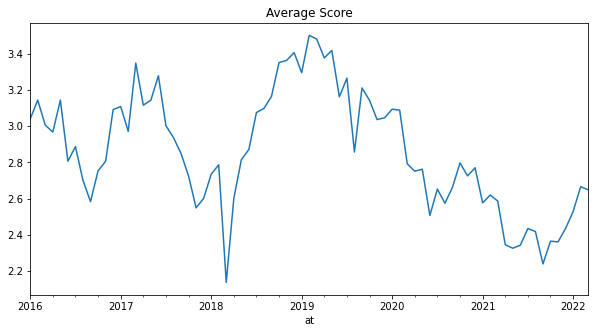

In [17]:
score_trend = clean_data.groupby(by=pd.Grouper(key="at", freq="M"))['score'].mean()
plt.figure(figsize=(10,5))
plt.title("Average Score")
score_trend.plot()

### Volume of comments by month

<AxesSubplot:title={'center':'# Comments'}, xlabel='at'>

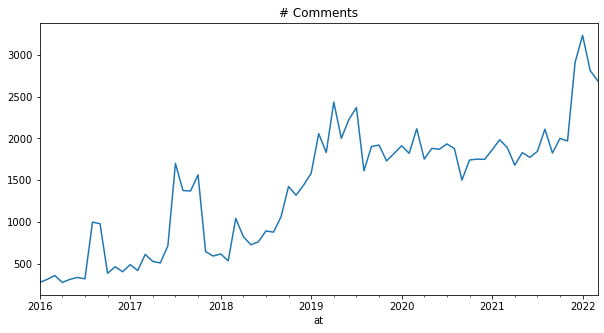

In [18]:
nComment_trend = clean_data.groupby(by=pd.Grouper(key="at", freq="M"))['content'].count()
plt.figure(figsize=(10,5))
plt.title("# Comments")
nComment_trend.plot()

### Topic modeling

In [20]:
# Topic modelling
extra_stopwords = ['app']


# Create Dictionary
data_words = list(map(lambda x: [w for w in x.split() if w not in extra_stopwords], clean_data['clean_content']))
id2word = corpora.Dictionary(data_words) 

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

In [22]:
# Build LDA model
num_topics = 5
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# # Save model
# model_path = "./models/ldaModel_topics-"+str(num_topics)
# with open(model_path, 'wb') as f:
#     pickle.dump(lda_model, f)

In [25]:
# Prepare visualization

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
model_path = "./models/ldaModelvis_topics-"+str(num_topics)
with open(model_path, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)


pyLDAvis.enable_notebook()
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.019932 -0.007204       1        1  29.873516
1     -0.041553  0.044884       2        1  19.192120
2      0.033200 -0.040250       3        1  17.816249
4     -0.063140 -0.028007       4        1  17.481088
3      0.051562  0.030577       5        1  15.637027, topic_info=        Term          Freq         Total Category  logprob  loglift
78      good  12057.000000  12057.000000  Default  30.0000  30.0000
74     great   9400.000000   9400.000000  Default  29.0000  29.0000
29      easy   2930.000000   2930.000000  Default  28.0000  28.0000
278    woman   9706.000000   9706.000000  Default  27.0000  27.0000
31   account   6686.000000   6686.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
192    would    864.967839   5086.792536   Topic5  -5.3397   0.0838
252     even    991.705173   8766.949756   Topic5  -5.2029  -0.3238
246   better    846.713167   5547.532632   Topic5  -5.3610  -0.0242
185     give    723.484542   3391.166241   Topic5  -5.5183   0.3107
0     bumble    766.752038  10543.917959   Topic5  -5.4602  -0.7656

[471 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
9904       2  0.949019  acceptance
31         1  0.142536     account
31         2  0.353721     account
31         3  0.080616     account
31         4  0.372866     account
...      ...       ...         ...
2340       4  0.047530         yay
2340       5  0.095060         yay
2071       3  0.034931         yep
2071       5  0.943144         yep
10261      4  0.960458       zilch

[1178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4])